In [1]:
import tensorflow as tf
import tensorflow.python.keras
import os
import sys
import numpy as np
import glob
import matplotlib.pyplot as plt


2023-04-26 16:14:17.052576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataFiles = os.path.join('ML_Data_Phys240_Sp23', '*')
testData = glob.glob(dataFiles)[1:-1]
trainSetHiPath = glob.glob(dataFiles)[0]
trainSetLoPath = glob.glob(dataFiles)[-1]

# print(glob.glob(dataFiles))

hiTrainMatrix = np.loadtxt(trainSetHiPath)
loTrainMatrix = np.loadtxt(trainSetLoPath)
# np.shape(highTrainMatrix) # (10_000, 104)

hiTrainMatrix = hiTrainMatrix[:, 4:] # ignore the first four
loTrainMatrix = loTrainMatrix[:, 4:] # ignore the first four

hiPlusLo = np.concatenate((hiTrainMatrix, loTrainMatrix))

# np.shape(hiPlusLo)

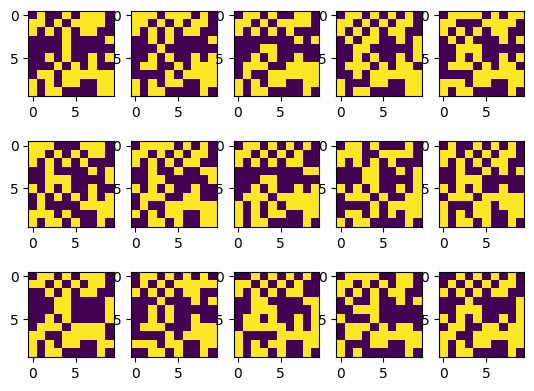

In [3]:
testImgs = np.reshape(hiPlusLo, (20_000, 10, 10, 1))
hiImgs = np.reshape(hiTrainMatrix, (10_000, 10, 10, 1))
loImgs = np.reshape(loTrainMatrix, (10_000, 10, 10, 1))

# using the variable axs for multiple Axes
fig, axs = plt.subplots(3, 5)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(hiImgs[i])
    
    

In [4]:
N = 20_000

p = np.random.permutation(N)

X = testImgs
X = testImgs[:, 1:-1, 1:-1, :] # truncates training imgs to 8x8
Y = np.zeros((N, 2))
Y[:N//2, 0] = 1
Y[N//2:, 1] = 1

# Shuffle X and Y in unison
X = X[p, :, :, :]
Y = Y[p, :]
X[X==0] = -1 # replace 0s with -1s

X_train = X[:8*N//10,:,:,:]
Y_train = Y[:8*N//10,:]
X_test = X[8*N//10:,:,:,:]
Y_test = Y[8*N//10:,:]

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D

def create_model():
    model = Sequential([
        Conv2D(filters=4,
               kernel_size=(3, 3),
               input_shape=(8, 8, 1)),
        Activation('relu'),
        Flatten(),
        Dense(units=8, activation='relu'),
        Dense(units=2, activation='softmax')
    ])

    return model

In [6]:
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 4)           40        
                                                                 
 activation (Activation)     (None, 6, 6, 4)           0         
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 8)                 1160      
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,218
Trainable params: 1,218
Non-trainable params: 0
_________________________________________________________________


In [7]:
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test),epochs=100, batch_size=100)

Epoch 1/100
160/160 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.5844 - val_loss: 0.6080 - val_accuracy: 0.6708
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.5575 - accuracy: 0.7096 - val_loss: 0.5266 - val_accuracy: 0.7280
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4872 - accuracy: 0.7635 - val_loss: 0.4722 - val_accuracy: 0.7747
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4478 - accuracy: 0.7857 - val_loss: 0.4517 - val_accuracy: 0.7857
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.7980 - val_loss: 0.4327 - val_accuracy: 0.8002
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4182 - accuracy: 0.8044 - val_loss: 0.4291 - val_accuracy: 0.8043
Epoch 7/100
160/160 [==============================] - 0s 2ms/step - loss: 0.4100 - accuracy: 0.8083 - val_loss: 0.4188 - val_accuracy: 0.8130

Epoch 58/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2735 - accuracy: 0.8839 - val_loss: 0.3501 - val_accuracy: 0.8503
Epoch 59/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2720 - accuracy: 0.8834 - val_loss: 0.3452 - val_accuracy: 0.8528
Epoch 60/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2722 - accuracy: 0.8846 - val_loss: 0.3505 - val_accuracy: 0.8525
Epoch 61/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2707 - accuracy: 0.8875 - val_loss: 0.3544 - val_accuracy: 0.8508
Epoch 62/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2707 - accuracy: 0.8853 - val_loss: 0.3587 - val_accuracy: 0.8522
Epoch 63/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2698 - accuracy: 0.8853 - val_loss: 0.3477 - val_accuracy: 0.8508
Epoch 64/100
160/160 [==============================] - 0s 2ms/step - loss: 0.2678 - accuracy: 0.8879 - val_loss: 0.3551 - val_accuracy:

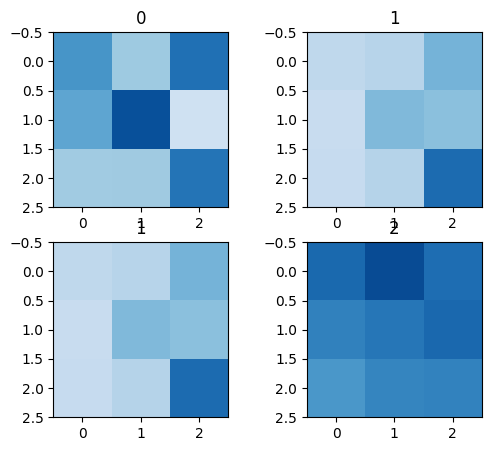

In [41]:
np.shape(model.get_weights()[0])
weights = model.get_weights()[0][:,:,0,:]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 5))
for i in range(2):
    for j in range(2):
        ax[i, j].set_title(f'{i+j}')
        ax[i, j].imshow(weights[:, :, i+j], interpolation='none', cmap='Blues', vmin=-1, vmax=1)
plt.show()
# for i in range(3):
#     plt.imshow(weights[:, :, i], interpolation='none', cmap='Blues', vmin=-1, vmax=1)

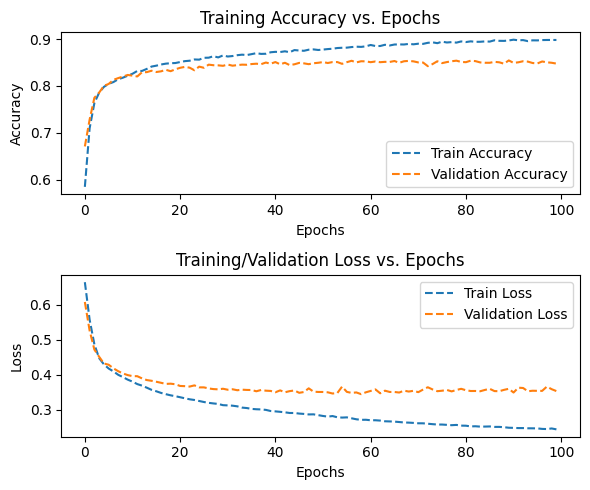

In [10]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 5))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, '--', label='Train Accuracy')
ax[0].plot(val_accuracy, '--', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, '--', label='Train Loss')
ax[1].plot(val_loss, '--', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

In [11]:
testData

['ML_Data_Phys240_Sp23/Expt_TestSet_3.dat',
 'ML_Data_Phys240_Sp23/Expt_TestSet_4.dat',
 'ML_Data_Phys240_Sp23/Expt_TestSet_1.dat',
 'ML_Data_Phys240_Sp23/Expt_TestSet_2.dat']

In [16]:
def test_routine(expPath):
    exp = np.loadtxt(expPath)
    exp = np.reshape(exp, (np.shape(exp)[0], 12, 12 , 1))
#     exp = exp[:, 1:-1, 1:-1, :] # cut out bg - now 10,10
    exp = exp[:, 2:-2, 2:-2, :] # cut out bg - now 8, 8
    
    fig, axs = plt.subplots(3, 5)
    fig.suptitle(expPath.split('/')[1]) # or plt.suptitle('Main title')
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(exp[i])

    y_pred = model.predict(exp, verbose=0)
    np.sum(y_pred)

    probs = y_pred[:, 0] - y_pred[:, 1]
    hotInds = np.where(probs > 0)
    percent = np.shape(hotInds)[-1]/np.shape(exp)[0]
    print(f'Model predicts {percent*100:.2f}% of the data is hot')
    


ML_Data_Phys240_Sp23/Expt_TestSet_3.dat
Model predicts 61.78% of the data is hot
ML_Data_Phys240_Sp23/Expt_TestSet_4.dat
Model predicts 63.06% of the data is hot
ML_Data_Phys240_Sp23/Expt_TestSet_1.dat
Model predicts 45.32% of the data is hot
ML_Data_Phys240_Sp23/Expt_TestSet_2.dat
Model predicts 48.50% of the data is hot


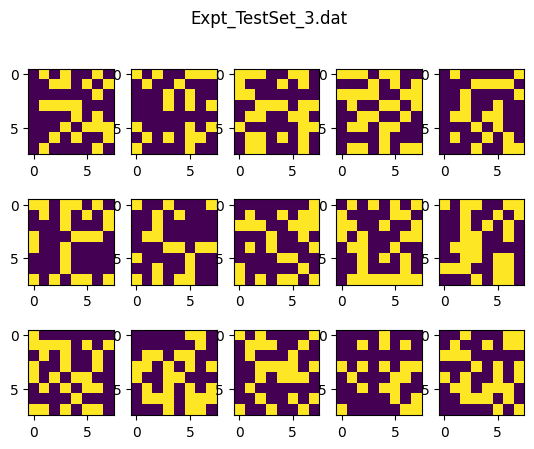

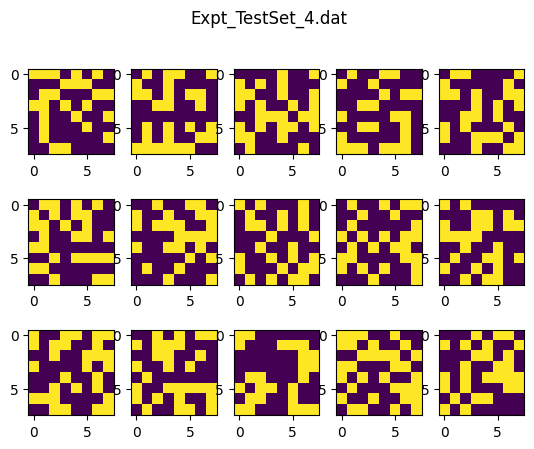

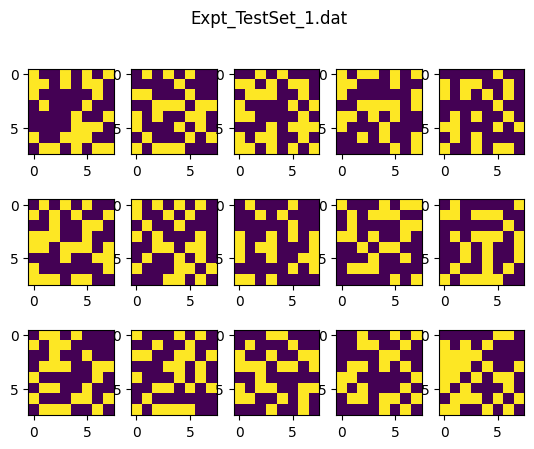

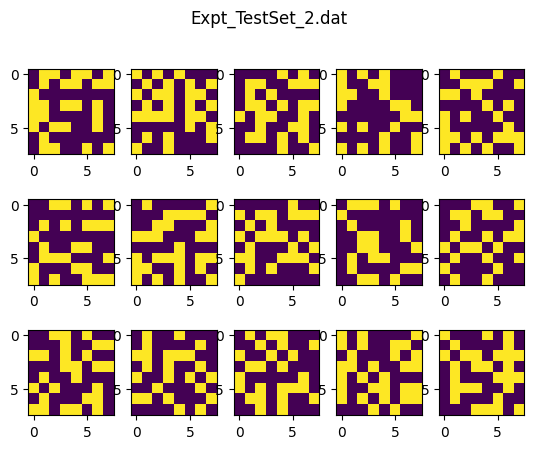

In [18]:
for i, d in enumerate(testData):
    print(d)
    test_routine(testData[i])